# Example: Two-Body Problem in an Inertial Frame

Recall the equations of motion for the two-body problem in an inertial frame:

$$\begin{aligned}\vector{R}_1 &= X_1\uvec{I} + Y_1\uvec{J} + Z_1\uvec{K}\\\vector{R}_2 &= X_2\uvec{I} + Y_2\uvec{J} + Z_2\uvec{K}\\\vector{V}_1 &= \dot{X}_1\uvec{I} + \dot{Y}_1\uvec{J} + \dot{Z}_1\uvec{K}\\\vector{V}_2 &= \dot{X}_2\uvec{I} + \dot{Y}_2\uvec{J} + \dot{Z}_2\uvec{K}\\\vector{A}_1 &= \ddot{X}_1\uvec{I} + \ddot{Y}_1\uvec{J} + \ddot{Z}_1\uvec{K}\\\vector{A}_2 &= \ddot{X}_2\uvec{I} + \ddot{Y}_2\uvec{J} + \ddot{Z}_2\uvec{K}\end{aligned}$$

where

$$\begin{aligned}\ddot{X}_1 &= G m_2 \frac{X_2 - X_1}{r^3} & \ddot{Y}_1 &= G m_2 \frac{Y_2 - Y_1}{r^3} & \ddot{Z}_1 &= G m_2 \frac{Z_2 - Z_1}{r^3}\\\ddot{X}_2 &= G m_1 \frac{X_1 - X_2}{r^3} & \ddot{Y}_2 &= G m_1 \frac{Y_1 - Y_2}{r^3} & \ddot{Z}_2 &= G m_1 \frac{Z_1 - Z_2}{r^3}\end{aligned}$$

In this Notebook, we will solve the two-body problem and produce several plots of the results.

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

First, we set the initial values and the constants. The initial position is with $m_1$ at the origin and $m_2$ 3000 km to the right of the origin.

In the function we will write, the state vector will be called $y$, so its initial value is $y_0$. Remember that the state vector includes 12 components, 6 positions and 6 velocities. These all need to be stored in one array.

In [2]:
G = 6.67430E-11  # m**3/(kg * s**2)
m_1 = m_2 = 1.0E26  # kg

R1_0 = np.array((0, 0, 0))*1000  # m
R2_0 = np.array((3000, 0, 0))*1000  # m
V1_0 = np.array((10, 20, 30))*1000  # m/s
V2_0 = np.array((0, 40, 0))*1000  # m/s

y_0 = np.hstack((R1_0, R2_0, V1_0, V2_0))
print(y_0)

[      0       0       0 3000000       0       0   10000   20000   30000
       0   40000       0]


Then, we need to define the function that describes the motion of our system. This function needs to compute the left hand side of the equation above ($\dot{\vector{y}}$) and return it to the solver, so that the solver can calculate the value of the state vector at time $t + \Delta t$.

The function takes the time $t$ and current value of the state vector $y$ as inputs. Because of the way that we constructed the initial values, the first 3 values of the state vector are the coordinates of $m_1$, the next 3 values are the coordinates of $m_2$, the next 3 values are the velocity components of $m_1$, and the last three values are the velocity components of $m_2$. However, if you construct your initial state vector in a different order, make sure you match that order in your function. It doesn't matter what order you choose, as long as you're consistent.

Inside the function, we use the values in the state vector to fill the `ydot` vector. Then, we return `ydot` back to the solver.

In [3]:
def absolute_motion(t, y):
    """Calculate the motion of a two-body system in an inertial reference frame.
    
    The state vector ``y`` should be in the order:
    
    1. Coordinates of $m_1$
    2. Coordinates of $m_2$
    3. Velocity components of $m_1$
    4. Velocity components of $m_2$
    """
    
    # Get the six coordinates for m_1 and m_2 from the state vector
    X_1, Y_1, Z_1 = y[:3]
    X_2, Y_2, Z_2 = y[3:6]
    
    # Fill the derivative vector with zeros
    ydot = np.zeros(len(y))
    
    # Set the first 6 elements of the derivative equal to the last
    # 6 elements of the state vector, which are the velocities
    ydot[:6] = y[6:]
    
    # Calculate the acceleration terms and fill them in to the rest
    # of the derivative array
    r = np.sqrt((X_2 - X_1)**2 + (Y_2 - Y_1)**2 + (Z_2 - Z_1)**2)
    Xddot = G * (X_2 - X_1) / r**3
    Yddot = G * (Y_2 - Y_1) / r**3
    Zddot = G * (Z_2 - Z_1) / r**3
    ydot[6] = Xddot * m_2
    ydot[7] = Yddot * m_2
    ydot[8] = Zddot * m_2
    ydot[9] = -Xddot * m_1
    ydot[10] = -Yddot * m_1
    ydot[11] = -Zddot * m_1
    return ydot

With the function defined, we can call `solve_ivp()`. We need to tell it the function it should solve, the beginning and end times, the initial state vector, and then some information to help control the output.

Once the solver finishes, the solution is stored in `sol.y`. Each column of `sol.y` corresponds to a single timestep and each row corresponds to one of the state variables. It is more convenient to work with the transpose of this array, so we do that and define `y`. Then we extract the position and velocity of each mass as a function of time, and compute the barycenter (the center of gravity of the system).

In [4]:
t_0 = 0  # seconds
t_f = 480  # seconds
t_points = np.linspace(t_0, t_f, 1000)

sol = solve_ivp(absolute_motion, [t_0, t_f], y_0, t_eval=t_points)
# MATLAB: ode45(absolute_motion, [t_0, t_f], y_0)

y = sol.y.T
R_1 = y[:, :3] / 1000  # km
R_2 = y[:, 3:6] / 1000  # km
V_1 = y[:, 6:9] / 1000  # km/s
V_2 = y[:, 9:] / 1000  # km/s
barycenter = (m_1 * R_1 + m_2 * R_2) / (m_1 + m_2)  # km

Finally, we construct some plots of the situation. In this first plot, we are plotting the absolute motion of each of the two masses as well as the barycenter. Notice that the barycenter moves in a straight line. This is a key feature of the solution of this problem, as we discussed above.

The two masses spiral around the barycenter. One way to imagine this system (to a first approximation) is as the Earth and the Moon viewed as though you were sitting on the Sun (but not rotating with the Sun). The Earth and Moon would move through space, and they would appear to be orbiting around each other.

<IPython.core.display.Javascript object>


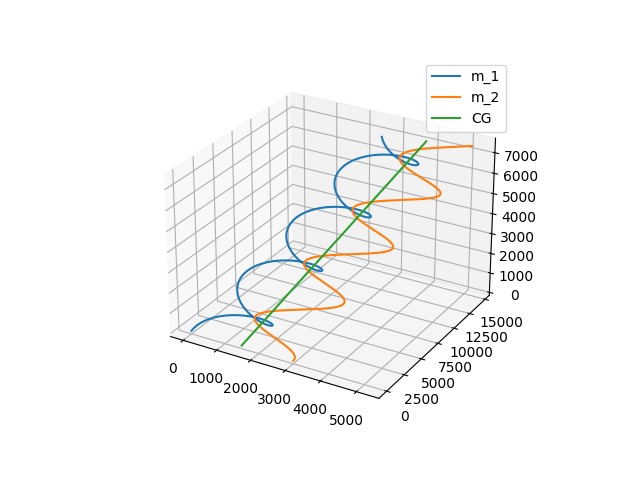

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(R_1[:, 0], R_1[:, 1], R_1[:, 2], label="m_1")
ax.plot(R_2[:, 0], R_2[:, 1], R_2[:, 2], label="m_2")
ax.plot(barycenter[:, 0], barycenter[:, 1], barycenter[:, 2], label="CG")
ax.legend();

Another way to view this plot is by setting the barycenter to be the origin of the coordinate system, rather than an external inertial frame. Remember that since the barycenter is moving with constant velocity, it is allowed to be used as an inertial reference frame. This is kind of like sitting above the barycenter of the Earth-Moon system. You would see them orbit around the barycenter, and the orbits would be ellipses.

<IPython.core.display.Javascript object>


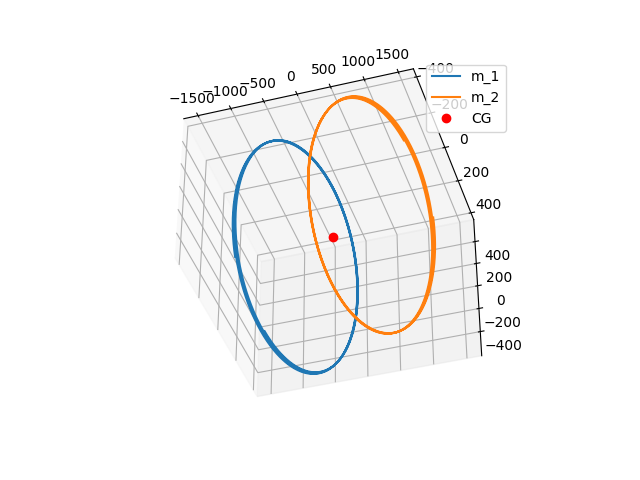

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
R1_rel_G = R_1 - barycenter
R2_rel_G = R_2 - barycenter
ax.plot(R1_rel_G[:, 0], R1_rel_G[:, 1], R1_rel_G[:, 2], label="m_1")
ax.plot(R2_rel_G[:, 0], R2_rel_G[:, 1], R2_rel_G[:, 2], label="m_2")
ax.plot(0, 0, 0, 'ro', label="CG")
ax.legend();

The final plot here fixes the coordinate system on the first mass and plots the motion of the barycenter and the second mass relative to the position of the first mass. This is kind of like sitting on the Earth and watching the Moon go around. Notice that the barycenter of the system also orbits around the first mass (relatively speaking).

<IPython.core.display.Javascript object>


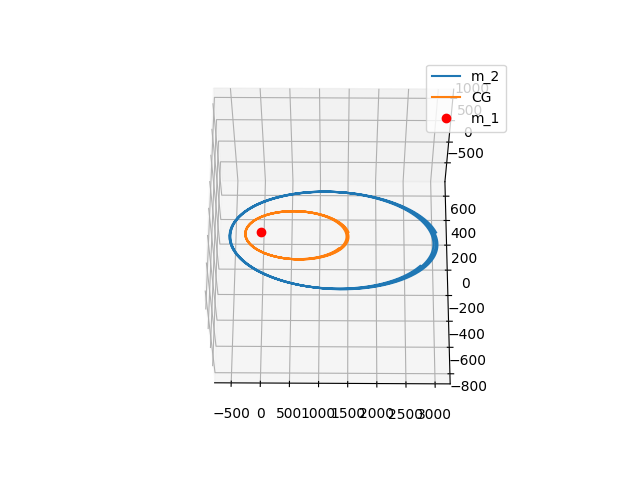

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
R2_rel_R1 = R_2 - R_1
G_rel_R1 = barycenter - R_1
ax.plot(R2_rel_R1[:, 0], R2_rel_R1[:, 1], R2_rel_R1[:, 2], label="m_2")
ax.plot(G_rel_R1[:, 0], G_rel_R1[:, 1], G_rel_R1[:, 2], label="CG")
ax.plot(0, 0, 0, "ro", label="m_1")
ax.legend();